In [0]:
pip install mlflow

Python interpreter will be restarted.
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-293e6d1c-39b0-446b-b889-9d446d8b6740
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Not uninstalling requests at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-293e6d1c-39b0-446b-b889-9d446d8b6740
    Can't uninstall 'requests'. No files were found to uninstall.
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-293e6d1c-39b0-446b-b889-9d446d8b674

In [0]:
pip install imblearn

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install xgboost

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# Databricks notebook source
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score

In [0]:
# create SparkSession
spark = SparkSession.builder.appName("Data").getOrCreate()

In [0]:
# Load the dataset
df = spark.read.csv("/FileStore/tables/customer_booking.csv", header=True, inferSchema=True)

In [0]:
# 將Spark DataFrame轉換為Pandas DataFrame以便進行機器學習 
data = df.toPandas()

In [0]:
# 数据概览
print(data.info())  # 检查数据类型和缺失值
print(data.describe())  # 查看数值变量的统计信息
print(data.head())  # 查看数据示例

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int32  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int32  
 4   length_of_stay         50000 non-null  int32  
 5   flight_hour            50000 non-null  int32  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int32  
 10  wants_preferred_seat   50000 non-null  int32  
 11  wants_in_flight_meals  50000 non-null  int32  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int32  
dtypes: float64(1), int32(8), object(5)
memory usage: 3.8+ 

In [0]:
# 检查分类变量
categorical_columns = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']

# 使用 One-Hot 编码
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# 确认编码后数据
print(data.head())

   num_passengers  purchase_lead  length_of_stay  flight_hour  \
0               2            262              19            7   
1               1            112              20            3   
2               2            243              22           17   
3               1             96              31            4   
4               2             68              22           15   

   wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
0                    1                     0                      0   
1                    0                     0                      0   
2                    1                     1                      0   
3                    0                     0                      1   
4                    1                     0                      1   

   flight_duration  booking_complete  sales_channel_Mobile  ...  \
0             5.52                 0                     0  ...   
1             5.52                 0            

In [0]:
# 选择需要标准化的列
numeric_columns = ['purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

# 标准化
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

print(data[numeric_columns].head())

   purchase_lead  length_of_stay  flight_hour  flight_duration
0       1.957530       -0.119353    -0.381764        -1.174175
1       0.299164       -0.089844    -1.120780        -1.174175
2       1.747470       -0.030824     1.465775        -1.174175
3       0.122272        0.234761    -0.936026        -1.174175
4      -0.187290       -0.030824     1.096267        -1.174175


In [0]:
# 假设有一个 DataFrame 叫 df
output_path = "/FileStore/tables/booking1.csv"
df.write.csv(output_path, header=True)

In [0]:
# 提取特征和目标变量
X = data.drop('booking_complete', axis=1)
y = data['booking_complete']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")

训练集大小: (40000, 918), 测试集大小: (10000, 918)


In [0]:
# 2. 数据平衡处理：应用 SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [0]:
# 使用 SMOTE 对训练数据进行过采样
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#Logistic Regression 

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 标准化特征数据
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression 模型训练
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# 预测与评估
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"Logistic Regression AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      6730
           1       0.85      0.85      0.85      6871

    accuracy                           0.85     13601
   macro avg       0.85      0.85      0.85     13601
weighted avg       0.85      0.85      0.85     13601

Logistic Regression AUC: 0.9284


/databricks/python/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest 模型训练
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 预测与评估
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      6730
           1       0.86      0.93      0.89      6871

    accuracy                           0.89     13601
   macro avg       0.89      0.89      0.89     13601
weighted avg       0.89      0.89      0.89     13601

Random Forest AUC: 0.9637


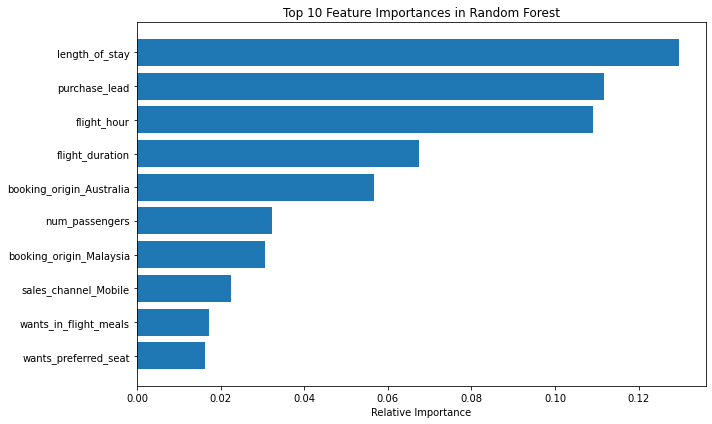

In [0]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `rf_model` is already trained, and `X` is your feature matrix
# Calculate feature importances
feature_importances = rf_model.feature_importances_

# Check if X is a DataFrame; if not, convert it with appropriate feature names
if isinstance(X, np.ndarray):
    # Replace with the actual feature names
    feature_names = [
    "num_passengers", 
    "purchase_lead", 
    "length_of_stay", 
    "flight_duration", 
    "wants_preferred_seat", 
    "wants_in_flight_meals", 
    "sales_channel_internet", 
    "sales_channel_agent", 
    "trip_type_round_trip", 
    "booking_origin_US", 
    "booking_origin_EU"
]
    X = pd.DataFrame(X, columns=feature_names)

# Ensure feature names and importances align
assert len(X.columns) == len(feature_importances), "Mismatch in feature names and importances"

# Sort feature importances and select top 10
sorted_idx = np.argsort(feature_importances)[-10:]  # Indices of the top 10 features

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Top 10 Feature Importances in Random Forest")
plt.tight_layout()
plt.show()



#Xgboost

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you already have X and y
# Example dataset for demonstration
X = np.random.rand(1000, 10)  # Replace with your actual dataset
y = np.random.randint(0, 2, 1000)  # Binary target variable

# Feature names for demonstration (replace with actual names)
feature_names = [
    "num_passengers", "purchase_lead", "length_of_stay", "flight_duration",
    "wants_preferred_seat", "wants_in_flight_meals", "sales_channel_internet",
    "sales_channel_agent", "trip_type_round_trip", "booking_origin"
]

# Convert X to DataFrame for feature names
X = pd.DataFrame(X, columns=feature_names)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [0]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

# Initialize and train the XGBoost classifier
xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.46      0.47        97
           1       0.51      0.52      0.52       103

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.49      0.49      0.49       200

AUC Score: 0.5187


In [0]:
# Extract feature importances
feature_importances = xgb_model.feature_importances_

# Ensure feature names align with feature importances
assert len(feature_importances) == len(feature_names), "Mismatch between feature names and importances!"

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Display the top features
print(importance_df.head(10))


                  Feature  Importance
7     sales_channel_agent    0.115314
9          booking_origin    0.109000
3         flight_duration    0.106932
8    trip_type_round_trip    0.106341
4    wants_preferred_seat    0.100003
0          num_passengers    0.097799
5   wants_in_flight_meals    0.092382
1           purchase_lead    0.092074
6  sales_channel_internet    0.090233
2          length_of_stay    0.089922


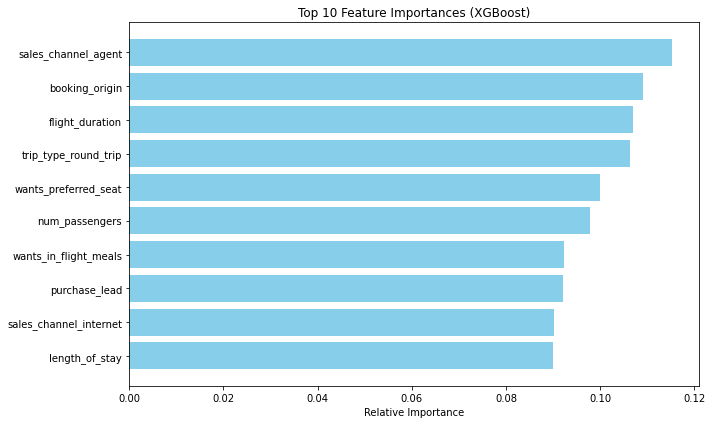

In [0]:
# Select the top 10 features
top_10_features = importance_df.head(10)

# Plot the top 10 feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_10_features["Feature"], top_10_features["Importance"], color="skyblue")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()
